# Inference on "Data"

* The purpose of this notebook is to allow for evaluation/sampling with a trained NF model on sector_scint data  
* We also compare the samples to real data (sector_sensor)

## Setup
**Package imports:**

In [1]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from IPython.display import clear_output
import time
from concurrent.futures import ThreadPoolExecutor
import matplotlib.ticker as plticker
import os
from typing import Union, List
from scipy.stats import norm

**local imports (written by me):**

In [2]:
from reco import process_data, create_dataloader, prepare_data_for_nn, create_dataloader,create_unique_mapping,calculate_num_pixels_z_dependence,process_data_one_segment,prepare_data_for_nn_one_segment
from util import PVect, theta_func, r_func,get_layer, create_layer_map,load_real_data

Using device cuda:0


In [3]:
from time_res_util import process_times,get_all_times,checkdir

In [ ]:
# Timing_path = "/cwork/rck32/eic/work_eic/macros/Timing_estimation/"

# #training data produced by preprocess
# raw_inputs = torch.load(Timing_path + "data/July_24/Run_1/Vary_p_events_file_0_July_23_600_z_pos.pt")
# for i in range(1,600):
#     clear_output(wait=True)
#     print(f"processed file #{i} or 600")
#     raw_inputs = torch.cat((raw_inputs, torch.load(Timing_path + f"data/July_24/Run_1/Vary_p_events_file_{i + 1}_July_23_600_z_pos.pt")),0)
    
# inputs = raw_inputs[np.logical_and(raw_inputs[:,4] < 100,raw_inputs[:,3] < 0.06)]

# indexes = torch.randperm(inputs.shape[0])
# dataset = inputs[indexes]
# train_frac = 0.08
# test_frac = 0.01
# val_frac = 0.01
# train_lim = int(np.floor(dataset.shape[0] * train_frac))
# test_lim = train_lim + int(np.floor(dataset.shape[0] * test_frac))
# val_lim = test_lim + int(np.floor(dataset.shape[0] * val_frac))
# train_data = dataset[:train_lim]
# test_data = dataset[train_lim:test_lim]
# val_data = dataset[test_lim:val_lim]

In [4]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Set parameters of model and data

In [5]:
import datetime
x = datetime.datetime.now()
today = x.strftime("%B_%d")

In [6]:
particle = "pi"
# particle = "mu"

# This data will be used for storing plots - today above works if you actually want today
today = "August_05"

run_num = 6
run_num_str = str(run_num)

#NF Stuff

K = 1 #num flows

latent_size = 1 #dimension of PDF
hidden_units = 64 #nodes in hidden layers
hidden_layers = 8
context_size = 3 #conditional variables for PDF
num_context = 3

K_str = str(K)
batch_size= 2000
hidden_units_str = str(hidden_units)
hidden_layers_str = str(hidden_layers)
batch_size_str = str(batch_size)

## Neural Spline Flow
model definition:

In [7]:
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)


Create directories / pick where to pull from

In [8]:
# model_date = "July_22"
model_date = "August_05"

model_path = "models/" + model_date + "/"
checkdir(model_path)

samples_path = "data/samples/" + today + "/"
checkdir(samples_path)

test_data_path = "data/test/" + today + "/"
checkdir(test_data_path)

test_dist_path = "plots/test_distributions/" + today + "/"
checkdir(test_dist_path)

Load model accoring to params above

In [9]:
model.load(model_path + "run_" + run_num_str + "_" + str(num_context)+ "context_" +K_str +  "flows_" + hidden_layers_str+"hl_" + hidden_units_str+"hu_" + batch_size_str+"bs.pth")
model = model.to(device)

model_compile = torch.compile(model,mode = "reduce-overhead")
model_compile = model_compile.to(device)

### Evaluation
load sector_scint root files with uproot

In [10]:
'''muon z pos vary'''

# Specify the directory path
directory = f"/cwork/rck32/eic/work_eic/root_files/August_2/segment_scint/"
filename = "run_1/mu_5GeV_5k_time_res.edm4hep.root"

file_path = os.path.join(directory, filename)
data = process_data_one_segment(file_path + ":events")

features, metadata= prepare_data_for_nn_one_segment(data)

In [11]:
# input_fig, input_axs = plot.subplots(1,3,figsize=(18,8))
# input_axs[0].hist(features[:,0],bins = 100)
# input_axs[1].hist(features[:,1],bins = 100)
# input_axs[2].hist(features[:,2],bins = 100)
# input_fig.show()

In [12]:
# Create DataLoader
batch_size_inference = 1000000
dataloader = create_dataloader(features, metadata, batch_size_inference,shuffle_bool=False)

# with torch.profiler.profile(activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA]) as prof:
min_time = 0
samples = torch.empty(features.shape[0],device = device)
context = torch.empty((features.shape[0],3),device = device)
event_idxs = torch.empty(features.shape[0],device = device)
it = 0
with torch.no_grad():
    for batch_features, batch_metadata in dataloader:
        context_features = batch_features[:, :3].clone().to(device)
        samples[batch_size_inference * it:(batch_size_inference * it) + len(batch_features)] = abs(model_compile.sample(num_samples=context_features.shape[0], context=context_features)[0]).squeeze(1)
        samples[it*batch_size_inference:(batch_size_inference * it) + len(batch_features)].add_(batch_features[:, 3].to(device))
        context[batch_size_inference * it:(batch_size_inference * it) + len(batch_features)] = context_features
        del batch_features
        it += 1
context = context.cpu().detach()
samples = samples.cpu().detach()
event_idxs = event_idxs.cpu().detach()

(402385, 4)


#### Open and merge all times from optph sims

In [13]:
uproot_path = f"/cwork/rck32/eic/work_eic/root_files/August_1/run_1cm_optph/"
flattened_times = get_all_times(uproot_path,multipleFiles = True)

### Compare total distributions

Text(0.5, 0.98, 'learned and real all times overlayed')

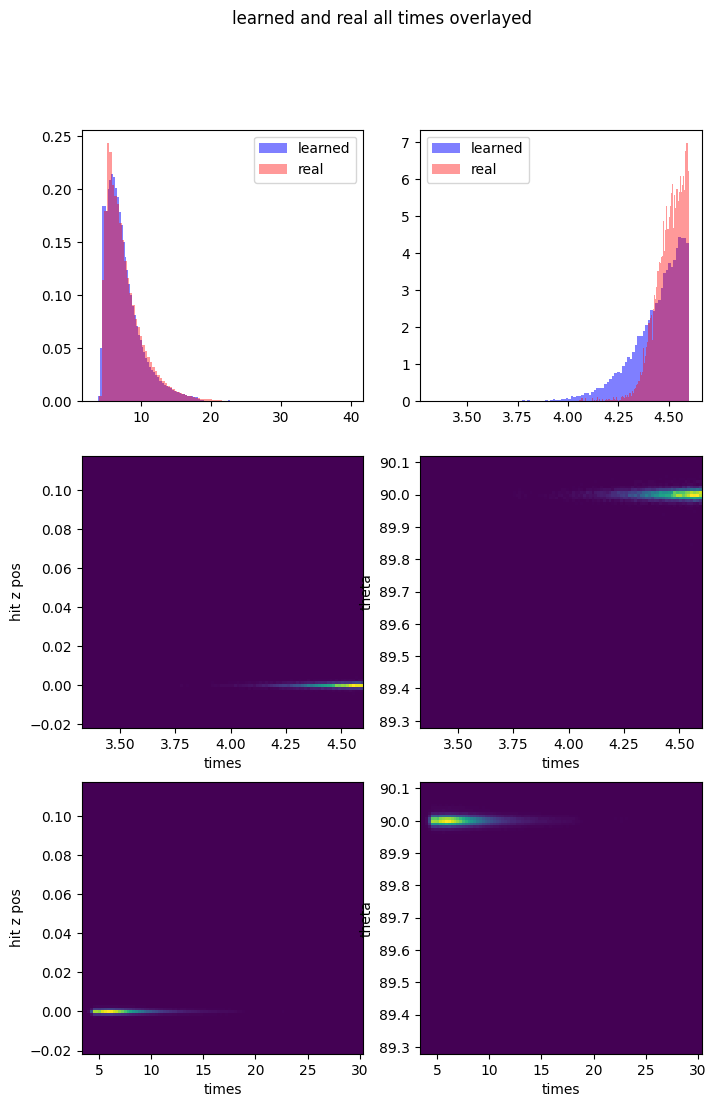

In [47]:
fig_all_times, axs_all_times = plot.subplots(3,2,figsize = (8,12))
axs_all_times[0,0].hist(samples,bins = 100,alpha = 0.5, color = "blue",density = True,label = "learned");
axs_all_times[0,0].hist(flattened_times,bins = 100,alpha = 0.4, color = "red",density = True,label = "real");
axs_all_times[0,0].legend()
samples_cut_indices = samples < 4.6
real_cut_indices = flattened_times < 4.6

axs_all_times[0,1].hist(samples[samples < 4.6],bins = 100,alpha = 0.5, color = "blue",density = True,label = "learned");
axs_all_times[0,1].hist(flattened_times[flattened_times < 4.6],bins = 100,alpha = 0.4, color = "red",density = True,label = "real");
axs_all_times[0,1].legend()

axs_all_times[1,0].hist2d(samples[samples_cut_indices],data_w_context[samples_cut_indices,0],bins = 100);
axs_all_times[1,0].set_xlabel("times")
axs_all_times[1,0].set_ylabel("hit z pos")
axs_all_times[1,1].hist2d(samples[samples_cut_indices],data_w_context[samples_cut_indices,1],bins = 100);
axs_all_times[1,1].set_xlabel("times")
axs_all_times[1,1].set_ylabel("theta")
axs_all_times[2,0].hist2d(samples,data_w_context[:,0],bins = 100);
axs_all_times[2,0].set_xlabel("times")
axs_all_times[2,0].set_ylabel("hit z pos")
axs_all_times[2,1].hist2d(samples,data_w_context[:,1],bins = 100);
axs_all_times[2,1].set_xlabel("times")
axs_all_times[2,1].set_ylabel("theta")
# axs_all_times[1,1].hist2D(flattened_times[real_cut_indices],data_w_context[samples_cut_indices,0],bins = 100);
fig_all_times.suptitle("learned and real all times overlayed")
# fig_all_times.savefig("plots/time_res/August_05/real_vs_learned_all_times_run_6.jpeg")

In [40]:
data_w_context = torch.cat((context,samples.unsqueeze(1)),dim=1)

## Timing Resolution
Need distribution of time of first photons

#### NF: Calculate first pixel times for events that pass threshold

In [20]:
threshold = 10
first_times = []
# Get unique event indices and their counts
unique_events, counts = torch.unique(event_idxs, return_counts=True)

# Find events that meet the threshold
valid_events = unique_events[counts > threshold]

# If there are valid events, process them
if valid_events.numel() > 0:
    # Create a mask for valid events
    mask = torch.isin(event_idxs, valid_events)

    # Get samples and events for valid events
    valid_samples = samples[mask]
    valid_event_indices = event_idxs[mask]

    # Sort samples and event indices
    sorted_indices = torch.argsort(valid_event_indices)
    sorted_samples = valid_samples[sorted_indices]
    sorted_events = valid_event_indices[sorted_indices]

    # Find the minimum sample for each event
    unique_events = torch.unique(sorted_events)
    min_samples = torch.tensor([sorted_samples[sorted_events == event].min() for event in unique_events])

    # Append to the corresponding sublist in the result list
    first_times.append(min_samples.tolist())

#### Optph: process times and get distribution

In [21]:
#Minimum number of pixels to be hit for us to accept event
threshold = 10

# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/August_1/run_1cm_optph/mu_5GeV_500_0.edm4hep.root:events"
uproot_path = f"/cwork/rck32/eic/work_eic/root_files/August_1/run_1cm_optph/"
accepted_times, second_lowest_list, avg_accepted_times = process_times(uproot_path, threshold,True)

total: 420414 | duplicates: 26316 | ratio: 0.06259544163610156 | num unique cells hit: 6507 | skipped: 0


### Compare first photon distributions

Text(0.5, 0.98, 'learned and real FIRST times overlayed')

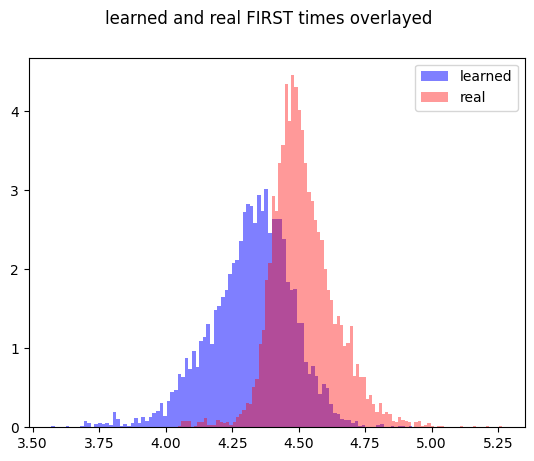

In [22]:
fig_first_times, axs_first_times = plot.subplots(1,1)
axs_first_times.hist(first_times,bins = 100,alpha = 0.5, color = "blue",density = True,label = "learned");
axs_first_times.hist(accepted_times,bins = 100,alpha = 0.4, color = "red",density = True,label = "real");
axs_first_times.legend()
fig_first_times.suptitle("learned and real FIRST times overlayed")
# fig_first_times.savefig("plots/time_res/August_2/real_vs_learned_first_times.jpeg")

#### NF: Plot time res for different z hit positions 

z:	-732	|	mean:	8.54	|	std:	0.48
z:	-657	|	mean:	8.44	|	std:	0.47
z:	-582	|	mean:	8.45	|	std:	0.46
z:	-507	|	mean:	8.51	|	std:	0.47
z:	-432	|	mean:	8.49	|	std:	0.47
z:	-357	|	mean:	8.34	|	std:	0.45
z:	-282	|	mean:	8.48	|	std:	0.48
z:	-207	|	mean:	8.53	|	std:	0.50
z:	-132	|	mean:	8.87	|	std:	0.63
z:	 -57	|	mean:	8.32	|	std:	0.46
z:	  18	|	mean:	8.47	|	std:	0.47
z:	  92	|	mean:	8.39	|	std:	0.48
z:	 167	|	mean:	8.38	|	std:	0.47
z:	 242	|	mean:	8.35	|	std:	0.45
z:	 317	|	mean:	8.37	|	std:	0.46
z:	 392	|	mean:	8.40	|	std:	0.46
z:	 467	|	mean:	8.52	|	std:	0.48
z:	 542	|	mean:	8.46	|	std:	0.47
z:	 617	|	mean:	8.43	|	std:	0.48
z:	 692	|	mean:	8.36	|	std:	0.46


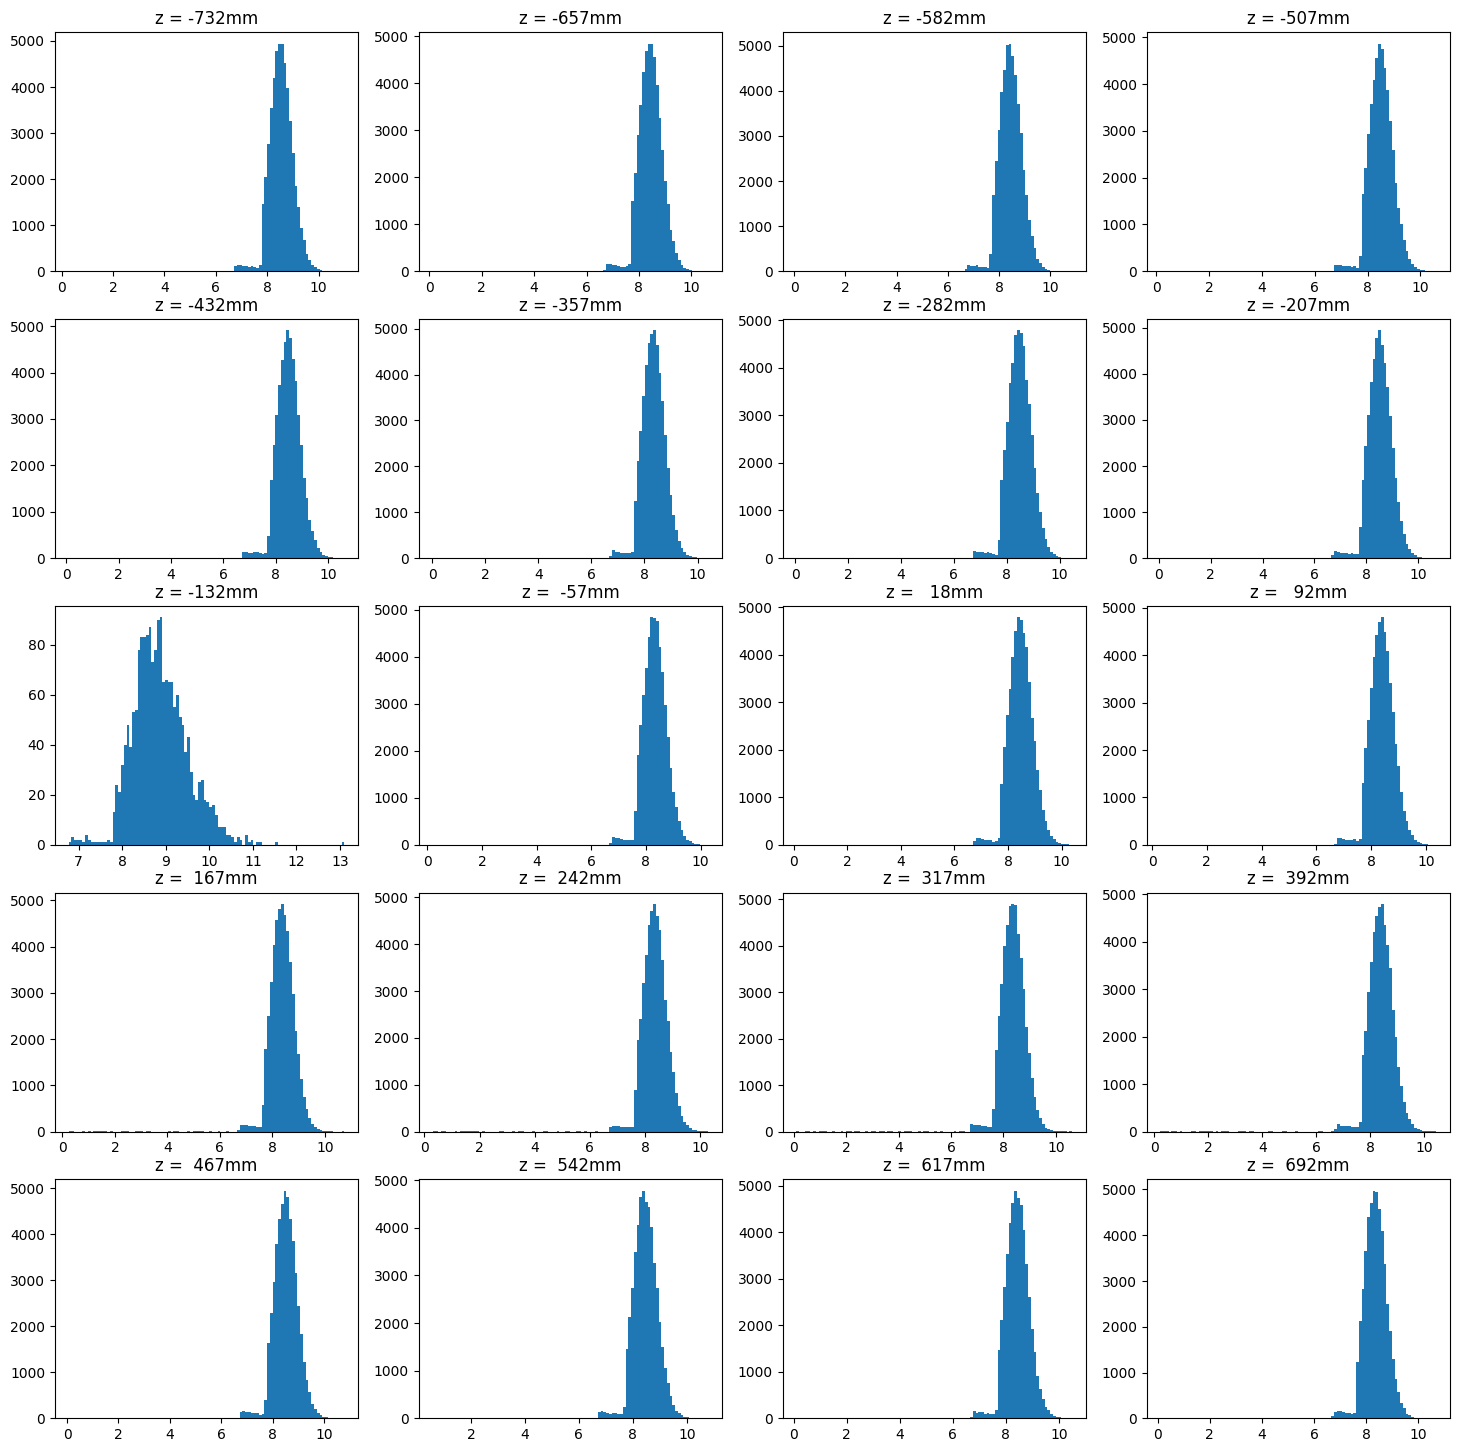

In [109]:
z_pos = -732
z_end = 767
z_num = 20
z_inc = (z_end - z_pos) / z_num 

fig,axs = plot.subplots(5,4,figsize=(18,18))

for i in range(5):
    for j in range(4):
        z_idx = i * 4 + j
        z_pos_string = "z = %4.0fmm"%z_pos
        (mu, sigma) = norm.fit(z_pos_first_times[z_idx])
        axs[i][j].hist(z_pos_first_times[z_idx],bins = 100)
        axs[i][j].set_title(z_pos_string)
        print("z:\t%4.0f\t|\tmean:\t%2.2f\t|\tstd:\t%2.2f"%(z_pos,mu,sigma))
        z_pos += z_inc
fig.savefig("plots/time_res/July_31/timing_res.jpeg")